In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, Reshape,Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.datasets import cifar10
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Lambda
import matplotlib.pyplot as plt
import random
import string

# Configuration
IMAGE_SIZE = (32, 32, 3)  # CIFAR-10 images are 32x32
MAX_TEXT_LENGTH = 50       # Reduced from 100 to better match small image size
BATCH_SIZE = 64
EPOCHS = 30
LEARNING_RATE = 0.0002
BIT_LENGTH = MAX_TEXT_LENGTH * 8  # 400 bits

In [2]:
# Text processing functions
def generate_random_text():
    """Generate random text for training"""
    length = random.randint(1, MAX_TEXT_LENGTH)
    chars = string.ascii_letters + string.digits + ' ,.!?'
    return ''.join(random.choice(chars) for _ in range(length))

def text_to_binary(text, max_length=MAX_TEXT_LENGTH):
    """Convert text to a padded binary string (length = max_length * 8)"""
    text = text[:max_length]  # Trim to max length
    binary_str = ''.join(format(ord(char), '08b') for char in text)
    # Pad with '0' to reach full bit length
    return binary_str.ljust(max_length * 8, '0')

def binary_to_text(binary_input):
    """Convert binary (string or array) back to text"""
    # Convert array to string if needed
    if isinstance(binary_input, (list, np.ndarray)):
        binary_str = ''.join(str(int(b)) for b in binary_input)
    elif isinstance(binary_input, str):
        binary_str = binary_input
    else:
        raise TypeError("Input must be a binary string, list, or NumPy array")

    # Convert 8-bit segments to characters
    text = ''
    for i in range(0, len(binary_str), 8):
        byte = binary_str[i:i+8]
        if byte == '00000000':  # Early stop on null character
            break
        text += chr(int(byte, 2))
    return text


In [3]:
# Load and prepare CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
(X_train, _), (_, _) = cifar10.load_data()
X_train = X_train.astype('float32') / 255.0  # Normalize to [0,1]

# Generate random text messages for each image
print("Generating random text messages...")
texts = [generate_random_text() for _ in range(len(X_train))]
binary_texts = np.array([np.array([float(b) for b in text_to_binary(t)]) for t in texts])

# Split into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, binary_texts, test_size=0.2, random_state=42)

Loading CIFAR-10 dataset...
170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Generating random text messages...


In [4]:
def build_encoder():
    """Build the encoder model that hides text in images"""
    # Inputs
    image_input = Input(shape=IMAGE_SIZE, name='cover_image')
    text_input = Input(shape=(BIT_LENGTH,), name='secret_text')

    # Reshape text
    text_reshaped = Reshape((10, 10, 4))(text_input)  # 10*10*4 = 400
    # After text reshaping
    text_reshaped = Conv2D(3, (1, 1), padding='same')(text_reshaped)
    text_upsampled = Lambda(lambda x: tf.image.resize(x, [32, 32]))(text_reshaped)
    text_upsampled = Conv2D(64, (3, 3), padding='same', activation='relu')(text_upsampled)

    # Image branch
    x = Conv2D(32, (3, 3), padding='same')(image_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Combine image and upsampled text
    x = Concatenate()([x, text_upsampled])

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    # Output stego image
    output = Conv2D(3, (3, 3), padding='same', activation='sigmoid')(x)

    return Model(inputs=[image_input, text_input], outputs=output, name='encoder')

In [5]:
# Decoder Network
def build_decoder():
    """Build the decoder model that extracts text from stego images"""
    stego_input = Input(shape=IMAGE_SIZE, name='stego_image')

    x = Conv2D(32, (3, 3), padding='same')(stego_input)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(64, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(128, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Flatten()(x)
    x = Dense(MAX_TEXT_LENGTH * 8, activation='sigmoid')(x)

    return Model(inputs=stego_input, outputs=x, name='decoder')


In [6]:
# Build and compile the models
print("Building models...")
encoder = build_encoder()
decoder = build_decoder()

# Combined model for training
stego_image = encoder([encoder.input[0], encoder.input[1]])
decoded_text = decoder(stego_image)
combined_model = Model(
    inputs=[encoder.input[0], encoder.input[1]],
    outputs=[stego_image, decoded_text],
    name='steganography_model'
)

Building models...


In [7]:
# Loss functions
def image_loss(y_true, y_pred):
    return MeanSquaredError()(y_true, y_pred)

def text_loss(y_true, y_pred):
    return BinaryCrossentropy()(y_true, y_pred)


In [8]:
# Compile models
encoder.compile(optimizer=Adam(LEARNING_RATE), loss='mse')
decoder.compile(optimizer=Adam(LEARNING_RATE), loss='binary_crossentropy')
combined_model.compile(
    optimizer=Adam(LEARNING_RATE),
    loss=[image_loss, text_loss],
    loss_weights=[0.7, 0.3]  # Higher weight for image quality
)

In [10]:
# Training
print("Starting training...")
history = combined_model.fit(
    [X_train, y_train],
    [X_train, y_train],
    validation_split=0.1,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1
)

Starting training...
Epoch 1/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 36s 54ms/step - decoder_loss: 0.0070 - encoder_loss: 0.0056 - loss: 0.0060 - val_decoder_loss: 0.0051 - val_encoder_loss: 0.0050 - val_loss: 0.0050
Epoch 2/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 23s 42ms/step - decoder_loss: 0.0033 - encoder_loss: 0.0048 - loss: 0.0044 - val_decoder_loss: 0.0050 - val_encoder_loss: 0.0043 - val_loss: 0.0045
Epoch 3/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - decoder_loss: 0.0030 - encoder_loss: 0.0045 - loss: 0.0041 - val_decoder_loss: 0.0048 - val_encoder_loss: 0.0041 - val_loss: 0.0043
Epoch 4/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 41s 40ms/step - decoder_loss: 0.0022 - encoder_loss: 0.0042 - loss: 0.0036 - val_decoder_loss: 0.0049 - val_encoder_loss: 0.0040 - val_loss: 0.0043
Epoch 5/30
563/563 ━━━━━━━━━━━━━━━━━━━━ 42s 41ms/step - decoder_loss: 0.0027 - encoder_loss: 0.0041 - loss: 0.0037 - val_decoder_loss: 0.0061 - val_encoder_loss: 0.0037 - val_loss: 0.0044
Epoch 6/30
563/563 ━━━━━━━━━━━━━━━━━━━━

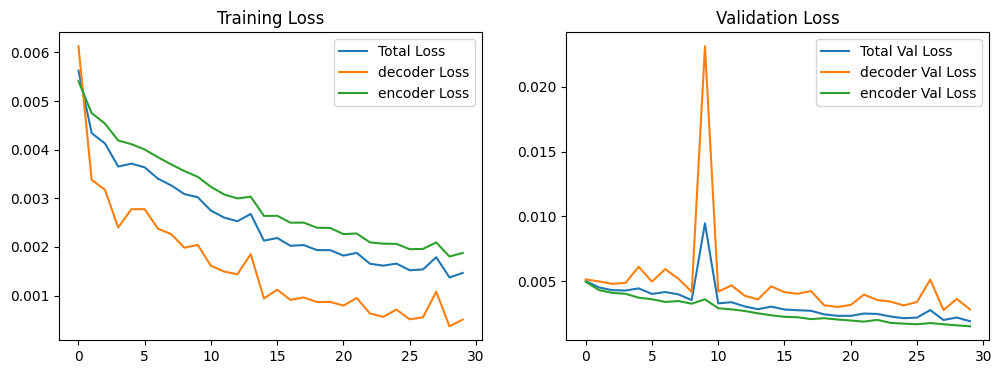

In [11]:
# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Total Loss')
plt.plot(history.history['decoder_loss'], label='decoder Loss')
plt.plot(history.history['encoder_loss'], label='encoder Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['val_loss'], label='Total Val Loss')
plt.plot(history.history['val_decoder_loss'], label='decoder Val Loss')
plt.plot(history.history['val_encoder_loss'], label='encoder Val Loss')
plt.title('Validation Loss')
plt.legend()
plt.show()


In [12]:
# Save models
encoder.save('steganography_encoder.h5')
decoder.save('steganography_decoder.h5')

In [13]:
# Demonstration functions
def hide_text_in_image(image_array, text):
    """Hide text in an image and return the stego image"""
    binary_text = np.array([float(b) for b in text_to_binary(text)])

    # Expand dimensions for batch
    image_batch = np.expand_dims(image_array, axis=0)
    text_batch = np.expand_dims(binary_text, axis=0)

    # Generate stego image
    stego_image = encoder.predict([image_batch, text_batch], verbose=0)[0]
    return stego_image

def extract_text_from_image(stego_image):
    """Extract hidden text from a stego image"""
    image_batch = np.expand_dims(stego_image, axis=0)
    binary_output = decoder.predict(image_batch, verbose=0)[0]
    binary_str = ''.join(['1' if bit > 0.5 else '0' for bit in binary_output])
    return binary_to_text(binary_str)


In [14]:
# Test with sample images
sample_idx = random.randint(0, len(X_val) - 1)
sample_image = X_val[sample_idx]
sample_text = binary_to_text(y_val[sample_idx])

print("\n=== Demonstration ===")
print("Original Text:", sample_text)

# Hide the text
stego_img = hide_text_in_image(sample_image, sample_text)

# Extract the text
extracted_text = extract_text_from_image(stego_img)
print("Extracted Text:", extracted_text)


=== Demonstration ===
Original Text: 2ga?k02pv.nOfa2C921I9bTjAJWeGHp.uGT zQCa,Xot
Extracted Text: 2ga?k02pv.nOfa2C921I9bTjAJWeGHp.uGT zQCa,Xot


In [15]:
# Calculate accuracy
original_binary = ''.join(['1' if b > 0.5 else '0' for b in y_val[sample_idx]])
extracted_binary = ''.join(['1' if b > 0.5 else '0' for b in decoder.predict(np.expand_dims(stego_img, axis=0), verbose=0)[0]])
bit_accuracy = sum(1 for a, b in zip(original_binary, extracted_binary) if a == b) / len(original_binary)
print(f"Bit Accuracy: {bit_accuracy:.2%}")

Bit Accuracy: 100.00%


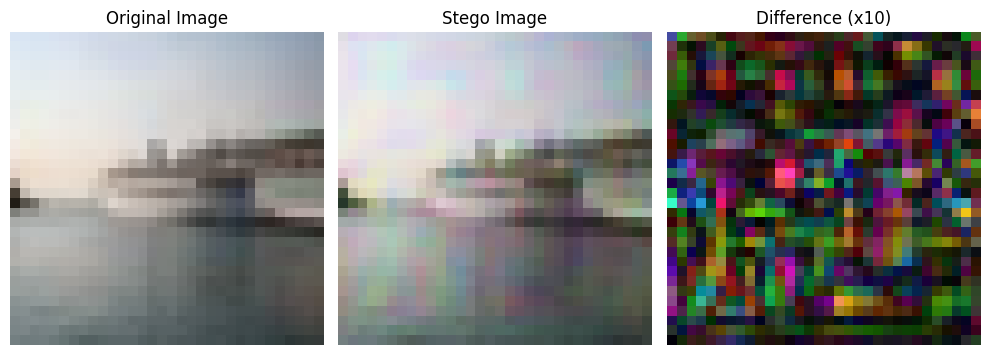

In [16]:
# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(sample_image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Stego Image")
plt.imshow(stego_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference (x10)")
plt.imshow(np.abs(sample_image - stego_img) * 10)
plt.axis('off')

plt.tight_layout()
plt.show()

In [17]:
from skimage.metrics import structural_similarity as ssim
import numpy as np

def evaluate_on_validation_set(X_val, y_val):
    total_bits = 0
    correct_bits = 0
    total_ssim = 0.0
    num_images = len(X_val)

    for i in range(num_images):
        original_image = X_val[i]
        original_bits = y_val[i]  # Already binary (numpy array of 0/1)

        # Hide binary data in image
        stego_image = encoder.predict([np.expand_dims(original_image, axis=0),
                                       np.expand_dims(original_bits, axis=0)], verbose=0)[0]

        # Extract binary data from image
        predicted_bits = decoder.predict(np.expand_dims(stego_image, axis=0), verbose=0)[0]
        predicted_bits = (predicted_bits > 0.5).astype(np.float32)  # Threshold to binary

        # Bitwise accuracy
        min_len = min(len(original_bits), len(predicted_bits))
        correct = np.sum(original_bits[:min_len] == predicted_bits[:min_len])
        total_bits += len(original_bits)
        correct_bits += correct

        # SSIM computation
        if original_image.shape[-1] == 3:  # RGB
            ssim_score = np.mean([
                ssim(original_image[:, :, c], stego_image[:, :, c], data_range=1.0)
                for c in range(3)
            ])
        else:
            ssim_score = ssim(original_image.squeeze(), stego_image.squeeze(), data_range=1.0)

        total_ssim += ssim_score

    # Results
    avg_bitwise_accuracy = correct_bits / total_bits
    avg_ssim = total_ssim / num_images

    print(f"Average Bitwise Accuracy: {avg_bitwise_accuracy * 100:.2f}%")
    print(f"Average SSIM: {avg_ssim:.4f}")


In [18]:
evaluate_on_validation_set(X_val, y_val)

Average Bitwise Accuracy: 99.92%
Average SSIM: 0.9414


In [19]:
from PIL import Image

# Load and preprocess custom image
custom_img_path = '/content/8.png'
img = Image.open(custom_img_path).convert("RGB").resize((32, 32))  # Ensure 3 channels
custom_image = np.array(img) / 255.0  # Normalize to [0,1]

custom_text = "Secret123"

# Step 1: Preprocess image (ensure shape is (1, 32, 32, 3))
custom_image_input = np.expand_dims(custom_image, axis=0)  # Add batch dimension

# Step 2: Convert text to binary and reshape (1, 400)
custom_text_bin = text_to_binary(custom_text)
custom_text_input = np.array([[int(bit) for bit in custom_text_bin]])

# Step 3: Pass through the encoder
stego_img = encoder.predict([custom_image_input, custom_text_input])[0]  # remove batch dim for display

# Step 4: Add batch dimension again for decoder
stego_input = np.expand_dims(stego_img, axis=0)
decoded_bits = decoder.predict(stego_input)[0]  # Output shape: (400,)

# Step 5: Threshold to get binary string
binary_out = ''.join(['1' if bit > 0.5 else '0' for bit in decoded_bits])

# Step 6: Convert back to text
extracted_text = binary_to_text(binary_out)

# Result
print("Original Text:", custom_text)
print("Extracted Text:", extracted_text)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Original Text: Secret123
Extracted Text: Secret123


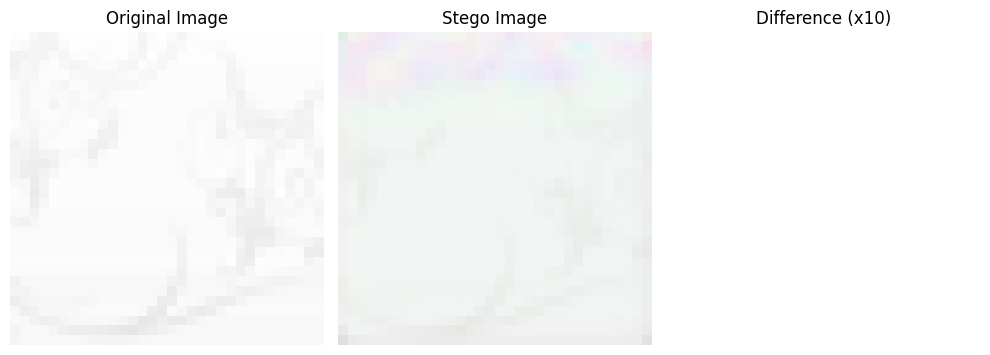

In [20]:
# Display results
plt.figure(figsize=(10, 5))

plt.subplot(1, 3, 1)
plt.title("Original Image")
plt.imshow(img)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title("Stego Image")
plt.imshow(stego_img)
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title("Difference (x10)")
plt.imshow(np.abs(img - stego_img) * 10)
plt.axis('off')

plt.tight_layout()
plt.show()

In [21]:
print(f"Training set size: {X_train.shape[0]} images")
print(f"Validation set size: {X_val.shape[0]} images")

Training set size: 40000 images
Validation set size: 10000 images
